In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# df = pd.read_csv('/Users/ashwin/Desktop/IIIT/work/4AM-10AM - Sheet1.csv')
df = pd.read_csv('/Users/ashwin/Desktop/150218623/150218623 cleaned.csv')
north, south, east, west = 12.931734, 12.920509, 77.628, 77.614182
n=50
filtered_df = df[(df['LAT'] >= south) & (df['LAT'] <= north) & (df['LONGITUDE'] >= west) & (df['LONGITUDE'] <= east)]
# observations = np.array(list(zip(filtered_df['LAT'].head(n), filtered_df['LONGITUDE'].head(n), filtered_df['IST_DATE'].head(n))))
observations = np.array(list(zip(filtered_df['LAT'].head(n), filtered_df['LONGITUDE'].head(n))))


print(len(observations))
obser = observations[17:37]
# print(len(obser))
# print(obser)
# print(filtered_df.head(n))

50


In [166]:
import osmnx as ox
# north, south, east, west = 12.89183, 12.920509, 77.625, 77.604182
north, south, east, west = 12.931734, 12.920509, 77.628, 77.614182
G = ox.graph_from_bbox(north, south, east, west, network_type='all')
nodes = list(G.nodes(data=True))
# states = [(data['y'], data['x']) for _, data in nodes]
states = np.array([(data['y'], data['x']) for _, data in nodes])
print(len(states))

/var/folders/g7/pjzz4q115nsb8sw2k_ff0dw80000gn/T/ipykernel_15486/1930751721.py:4: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead.
  G = ox.graph_from_bbox(north, south, east, west, network_type='all')


399


In [143]:
lat_lon = filtered_df.head(20)[['LAT', 'LONGITUDE']].values[19]
distances = np.linalg.norm(states - lat_lon, axis=1)
closest_node_index = np.argmin(distances)
closest_node = states[closest_node_index]
print("Closest node coordinates:", closest_node)

print(closest_node_index)


Closest node coordinates: [12.9308594 77.6141891]
311


In [159]:
import numpy as np
from math import exp, sqrt, pi

pairwise_distances = []
for i in range(len(observations) - 1):
    x1, y1 = observations[i]
    x2, y2 = observations[i + 1]
    distance = sqrt((x2 - x1)**2 + (y2 - y1)**2)
    pairwise_distances.append(distance)
TRANS = np.zeros((len(states), len(states), len(observations)-1))

beta = 0.95  

n = len(states)
for k in range(len(observations)-1):
    for i in range(n):
        for j in range(n):
            xtemp = np.linalg.norm(states[i] - states[j])
            dij = abs(xtemp - pairwise_distances[k])
            TRANS[i, j, k] = (1 / beta) * exp(-dij / beta)
        TRANS[i, :, k] = TRANS[i, :, k] / np.sum(TRANS[i, :, k])

sigztemp = []
for i in range(len(observations)):
    for j in range(len(states)):
        sigztemp.append(np.linalg.norm(observations[i] - states[j]))
sigz = 1.4 * np.median(sigztemp)

EMIS = np.zeros((len(states), len(observations)))
for i in range(len(observations)):
    for j in range(len(states)):
        EMIS[j, i] = (1 / (sqrt(2 * pi) * sigz)) * exp(-0.5 * ((np.linalg.norm(observations[i] - states[j])) / sigz) ** 2)

# seq = [1, 2, 3, 4]
seq = np.arange(1, len(observations)+1)

PRIOR = np.array([(1 / len(states))] * len(states))
# PRIOR[358] = 0.7

T = len(seq)  # Number of observations
n = EMIS.shape[0]  # Number of states

score = np.zeros((n, T))
pred = np.zeros((n, T))

for i in range(n):
    score[i, 0] = PRIOR[i] * EMIS[i, seq[0] - 1]

for t in range(1, T):
    for j in range(n):
        tscore = np.zeros(n)
        for k in range(n):
            tscore[k] = score[k, t - 1] * TRANS[k, j, t - 1] * EMIS[j, seq[t] - 1]
        score[j, t] = np.max(tscore)
        id = np.where(tscore == np.max(tscore))[0][0]
        pred[j, t] = id

IT = np.zeros(T, dtype=int)
IT[-1] = np.argmax(score[:, -1])

for t in range(T - 1, 0, -1):
    IT[t - 1] = int(pred[IT[t], t])

print(IT)

[385 333 304 123 209 251 154 160 130  81  38 337 198 127  70 311 311  70
 341 329  75  75 309 228 235 230 257 164  77 136  73  48 255 247 244 244
  74 391 242 382 373 326 301 301 301 301 300 300 300 128]


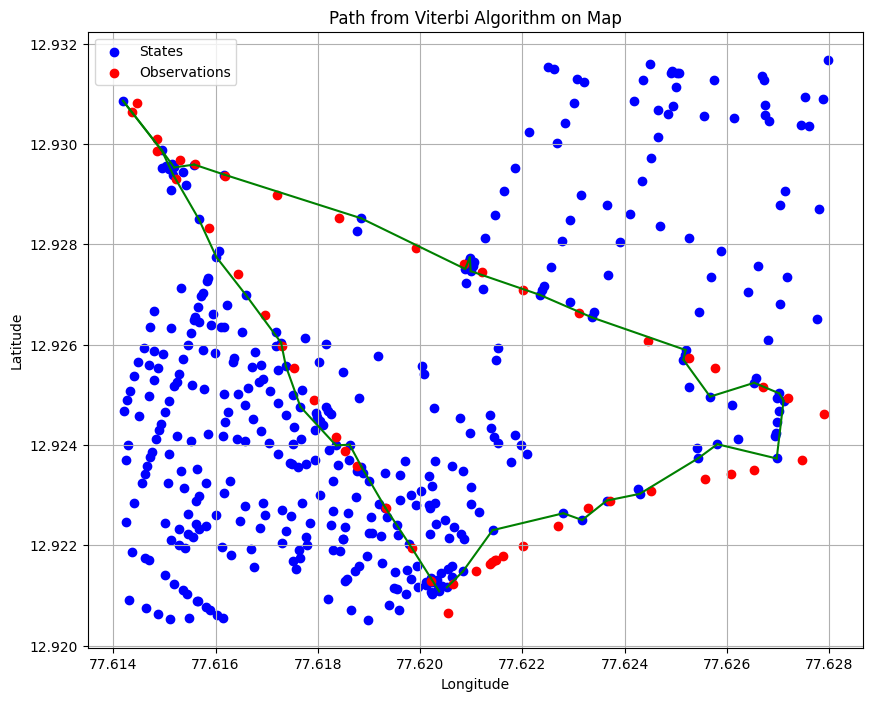

In [160]:
plt.figure(figsize=(10, 8))
plt.scatter(states[:, 1], states[:, 0], color='blue', label='States')
plt.scatter(observations[:, 1], observations[:, 0], color='red', label='Observations')
for i in range(len(IT) - 1 - 0):
    start_point = states[IT[i]]
    end_point = states[IT[i + 1]]
    plt.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]], color='green')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Path from Viterbi Algorithm on Map')
plt.legend()
plt.grid(True)
plt.show()

In [161]:
import numpy as np
from math import exp, sqrt, pi
# states = np.array([(0,0), (0,0.5), (0,1), (0,1.5), (0,2), (0.2,2), (0.5,2), (0.7,2), (1,2)])
# observations = np.array([(0.01,0.52), (-0.02,0.98), (0.18,2.02), (0.72,1.95)])
# observations = np.array([(-0.2,0.5), (-0.2,1.5), (0.2,1.8), (1,2.2)])

pairwise_distances = []
for i in range(len(obser) - 1):
    x1, y1 = obser[i]
    x2, y2 = obser[i + 1]
    distance = sqrt((x2 - x1)**2 + (y2 - y1)**2)
    pairwise_distances.append(distance)
TRANS = np.zeros((len(states), len(states), len(obser)-1))

beta = 0.95  

n = len(states)
for k in range(len(obser)-1):
    for i in range(n):
        for j in range(n):
            xtemp = np.linalg.norm(states[i] - states[j])
            dij = abs(xtemp - pairwise_distances[k])
            TRANS[i, j, k] = (1 / beta) * exp(-dij / beta)
        TRANS[i, :, k] = TRANS[i, :, k] / np.sum(TRANS[i, :, k])

sigztemp = []
for i in range(len(obser)):
    for j in range(len(states)):
        sigztemp.append(np.linalg.norm(obser[i] - states[j]))
sigz = 1.4 * np.median(sigztemp)

EMIS = np.zeros((len(states), len(obser)))
for i in range(len(obser)):
    for j in range(len(states)):
        EMIS[j, i] = (1 / (sqrt(2 * pi) * sigz)) * exp(-0.5 * ((np.linalg.norm(obser[i] - states[j])) / sigz) ** 2)

# seq = [1, 2, 3, 4]
seq = np.arange(1, len(obser)+1)

PRIOR = np.array([(1 / len(states))] * len(states))
# PRIOR[358] = 0.7

T = len(seq)  # Number of observations
n = EMIS.shape[0]  # Number of states

score = np.zeros((n, T))
pred = np.zeros((n, T))

for i in range(n):
    score[i, 0] = PRIOR[i] * EMIS[i, seq[0] - 1]

for t in range(1, T):
    for j in range(n):
        tscore = np.zeros(n)
        for k in range(n):
            tscore[k] = score[k, t - 1] * TRANS[k, j, t - 1] * EMIS[j, seq[t] - 1]
        score[j, t] = np.max(tscore)
        id = np.where(tscore == np.max(tscore))[0][0]
        pred[j, t] = id

IT = np.zeros(T, dtype=int)
IT[-1] = np.argmax(score[:, -1])

for t in range(T - 1, 0, -1):
    IT[t - 1] = int(pred[IT[t], t])

print(IT)

[ 70 341 329  75  75 309 228 235 230 257 164  77 136  73  48 255 247 244
 244  74]


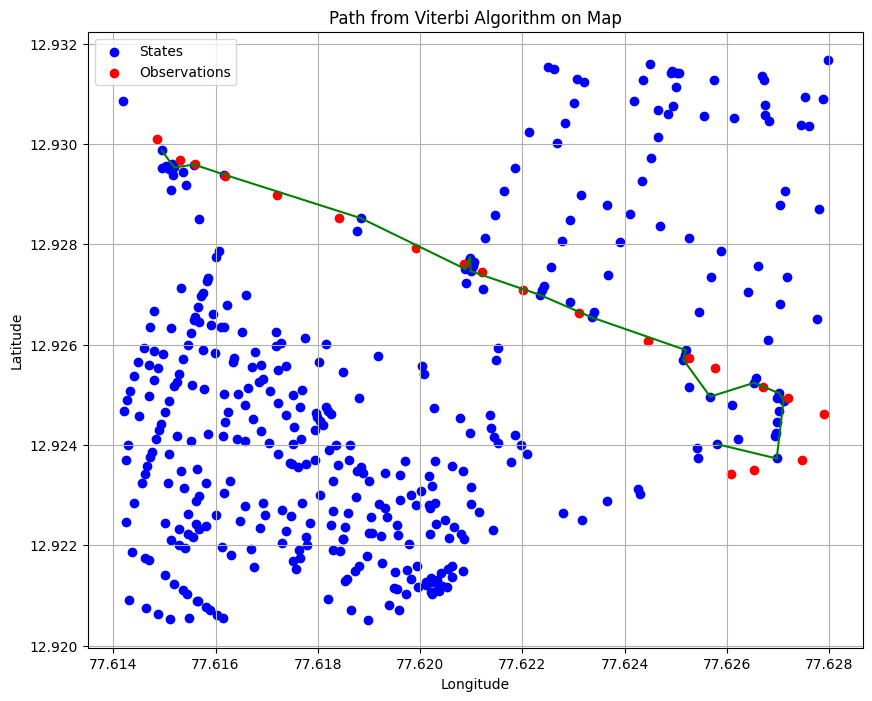

In [162]:
plt.figure(figsize=(10, 8))
plt.scatter(states[:, 1], states[:, 0], color='blue', label='States')
plt.scatter(obser[:, 1], obser[:, 0], color='red', label='Observations')
for i in range(len(IT) - 1 - 0):
    start_point = states[IT[i]]
    end_point = states[IT[i + 1]]
    plt.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]], color='green')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Path from Viterbi Algorithm on Map')
plt.legend()
plt.grid(True)
plt.show()